## Wan Yi Lam (S4060745)

In [10]:
import praw
import json 
from redditClient import redditClient
import os 
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# Function to recursively fetch and format comments and their replies
def get_formatted_comments_with_replies(comment_forest):
    """
    Processes a PRAW CommentForest 
    and returns a list of comment dictionaries, each potentially containing replies.
    It's assumed that replace_more(limit=0) has been called on the parent
    submission's comments or the higher-level comment forest.
    """
    formatted_comments = []
    comment_forest.replace_more(limit=0) # Expand this level of replies

    for item in comment_forest.list():
        # PRAW will yield Comment objects. MoreComments should be gone after replace_more.
        if isinstance(item, (praw.models.MoreComments)):
            # MoreComments is a placeholder for loading more comments.
            continue
        if not hasattr(item, 'author'): # Safety check for malformed dummy or unexpected PRAW object
            continue

        comment_dict = {
            "id": item.id,
            "author": item.author.name if item.author else "[deleted]",
            "created": item.created_utc,
            "text": item.body,
            "score": item.score, # Added score for comments
            "replies": [] # Initialize replies list for this comment
        }

        # Recursively process replies for the current comment
        if item.replies: # Check if there are replies to process
            comment_dict["replies"] = get_formatted_comments_with_replies(item.replies)
        
        formatted_comments.append(comment_dict)
    return formatted_comments


# Subreddit name and keywords to scrape
sSubredditName = 'disney+disneyprincess+movies+MovieSuggestions+angelinajolie' 
search_keywords = ["maleficent movie"] 
search_query = " ".join(search_keywords)

client = redditClient() 

try:
    print(f"Authenticated as: {client.user.me()}")
except Exception as e:
    print(f"Could not get current user: {e}. This is normal for script-only auth.")

subreddit = client.subreddit(sSubredditName)
submissions_data = []

print(f"\nSearching for submissions in '{sSubredditName}' with keywords: '{search_query}'")

for submission in subreddit.search(query=search_query, sort='top', limit = 40): # set limit
    submission_dict = {
        "title": submission.title,
        "author": submission.author.name if submission.author else "[deleted]",
        "content": submission.selftext,
        "score": submission.score,
        "created": submission.created_utc,
        "id": submission.id,
        "comments": []
    }

    # prepares the entire comment tree
    submission.comments.replace_more(limit=0)
    
    # process the top-level comments and their replies using our recursive function
    submission_dict["comments"] = get_formatted_comments_with_replies(submission.comments)
    
    submissions_data.append(submission_dict)

output = {"submissions": submissions_data}
output_filename = "reddit_posts_maleficent.json"
with open(output_filename, "w", encoding="utf-8") as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

print(f"\nData saved to {output_filename}")
if not submissions_data:
    print("No submissions found matching the criteria.")
else:
    print(f"Found {len(submissions_data)} submissions.")

In [ ]:
# Input file of reddit posts
redditFile = 'reddit_posts_maleficent.json' 
# Output file for the processed JSON data
outputFile = 'reddit_posts_maleficent_processed.json'

# Read and process the JSON file
with open(redditFile, 'r', encoding='utf-8') as f:
    SubredditData = json.load(f)

# Functions for Analysis (Counting and Timestamp Collection)
submissions_timestamps = []
all_comments_timestamps_refined = [] # Stores timestamps for all non-deleted comments and replies
total_top_level_comments = 0
total_replies_only_count = 0

def comments_and_count_replies_recursive(comments_list, is_top_level_comment_list=True):
    """
    Recursively processes a list of comments for analysis (counting, timestamps).
    - Skips comments/replies if author is "[deleted]".
    - Does not modify the input data structure.
    """
    global total_top_level_comments, total_replies_only_count, all_comments_timestamps_refined

    for comment_item in comments_list:
        if comment_item.get('author') == '[deleted]':
            continue

        comment_time_unix = comment_item.get('created', 0)
        if comment_time_unix:
            comment_time = datetime.fromtimestamp(comment_time_unix)
            all_comments_timestamps_refined.append(comment_time)

        if is_top_level_comment_list:
            total_top_level_comments += 1
        else:
            total_replies_only_count += 1

        replies = comment_item.get('replies', [])
        if replies:
            comments_and_count_replies_recursive(replies, is_top_level_comment_list=False)

# Function for Filtering Data Structure (for JSON)
def filter_deleted_items_recursive(items_list):
    """
    Recursively filters out items (comments/replies) where author is "[deleted]".
    Returns a new list of items with deleted ones removed.
    Modifies the 'replies' or 'comments' key in the returned items.
    """
    filtered_items = []
    if not items_list: # Handle empty or non-existent list 
        return []

    for item_dict in items_list:
        if item_dict.get('author') == '[deleted]':
            continue  # Skip this deleted item

        # Create a copy to modify, especially its 'replies'
        non_deleted_item = item_dict.copy()

        # Recursively filter its replies (if it's a comment structure)
        if 'replies' in item_dict:
            original_replies = item_dict.get('replies', [])
            filtered_sub_replies = filter_deleted_items_recursive(original_replies)

            if filtered_sub_replies:
                non_deleted_item['replies'] = filtered_sub_replies
            else:
                # If, after filtering replies, there are no non-deleted replies,
                # remove the 'replies' key from this item if it exists.
                if 'replies' in non_deleted_item:
                    del non_deleted_item['replies']
        
        filtered_items.append(non_deleted_item)
    return filtered_items


# Perform Analysis on Original Data (counts, timestamps) 
submissions_data_for_df = []
for submission in SubredditData.get('submissions', []):
    submission_time_unix = submission.get('created', 0)
    if submission_time_unix:
        submission_time = datetime.fromtimestamp(submission_time_unix)
        submissions_timestamps.append(submission_time)
        submissions_data_for_df.append({'timestamp': submission_time, 'type': 'Submission'})
    
    top_level_comments_list = submission.get('comments', [])
    if top_level_comments_list:
        comments_and_count_replies_recursive(top_level_comments_list, is_top_level_comment_list=True)

# Prepare Filtered Data for JSON
FilteredSubredditData = {"submissions": []}

for original_submission_dict in SubredditData.get('submissions', []):
    # Create a shallow copy of the submission. We'll modify its 'comments' part.
    submission_for_output = original_submission_dict.copy()

    # Filter comments for this submission
    original_top_level_comments = original_submission_dict.get('comments', [])
    filtered_top_level_comments = filter_deleted_items_recursive(original_top_level_comments)

    # Update the comments in the submission_for_output
    if filtered_top_level_comments:
        submission_for_output['comments'] = filtered_top_level_comments
    else:
        # If, after filtering, there are no comments (either none originally or all deleted),
        # remove the 'comments' key if it exists in the copied submission.
        if 'comments' in submission_for_output:
            del submission_for_output['comments']
    
    FilteredSubredditData["submissions"].append(submission_for_output)

# Write the Filtered Data to a New JSON File 
try:
    with open(outputFile, 'w', encoding='utf-8') as f_out:
        json.dump(FilteredSubredditData, f_out, indent=2, ensure_ascii=False)
    print(f"\nSuccessfully wrote processed data (with '[deleted]' author items removed) to '{outputFile}'")
except Exception as e:
    print(f"Error writing processed data to '{outputFile}': {e}")

# Continue with DataFrame Creation 
df_submissions = pd.DataFrame(submissions_data_for_df)
df_all_comments = pd.DataFrame({'timestamp': all_comments_timestamps_refined, 'type': 'Comment/Reply'})

if not df_submissions.empty and not df_all_comments.empty:
    df_combined = pd.concat([df_submissions, df_all_comments])
elif not df_submissions.empty:
    df_combined = df_submissions
elif not df_all_comments.empty:
    df_combined = df_all_comments
else:
    df_combined = pd.DataFrame(columns=['timestamp', 'type'])

print("\nActivity Statistics:")
print(f"Total Submissions: {len(submissions_timestamps)}")
print(f"Total Top-Level Comments: {total_top_level_comments}")
print(f"Total Replies : {total_replies_only_count}")
total_all_active_comments_and_replies = total_top_level_comments + total_replies_only_count
print(f"Total Comments and Replies: {total_all_active_comments_and_replies}")

if not df_combined.empty and 'timestamp' in df_combined.columns and not df_combined['timestamp'].empty:
    min_date = min(df_combined['timestamp']).date()
    max_date = max(df_combined['timestamp']).date()
    print(f"\nDate Range of Activity (based on non-deleted items): \n{min_date} to {max_date}")
else:
    print("\nNo activity data to determine date range.")


Successfully wrote processed data (with '[deleted]' author items removed) to 'reddit_posts_maleficent_processed.json'

Activity Statistics:
Total Submissions: 39
Total Top-Level Comments: 3954
Total Replies : 21357
Total Comments and Replies: 25311

Date Range of Activity (based on non-deleted items): 
2013-11-13 to 2025-05-23


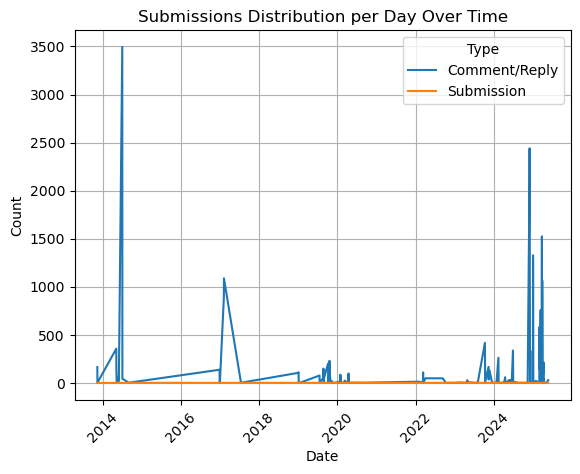

In [11]:
# Submissions distribution per day
df_combined['date'] = df_combined['timestamp'].dt.date
df_day = df_combined.groupby(['date', 'type']).size().unstack(fill_value=0)
df_day.plot(kind='line')
plt.title('Submissions Distribution per Day Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.grid(True)